In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

from tensorflow.keras.preprocessing import image_dataset_from_directory

In [2]:
PATH = os.path.dirname('../Images/train/')
BATCH_SIZE = 32
IMG_SIZE = (160, 160)


In [3]:
# script trouvé dans cette doc https://keras.io/examples/vision/image_classification_from_scratch/
# Permet de supprimer les images qui sont corrompus
import os

num_skipped = 0
for folder_name in os.listdir(PATH):
    folder_path = os.path.join(PATH, folder_name)


    if folder_name == ".DS_Store":
        continue

    for fname in os.listdir(folder_path):
        fpath = os.path.join(folder_path, fname)
        try:
            fobj = open(fpath, "rb")
            is_jfif = tf.compat.as_bytes("JFIF") in fobj.peek(10)
        finally:
            fobj.close()

        if not is_jfif:
            num_skipped += 1
            # Delete corrupted image
            os.remove(fpath)

print("Deleted %d images" % num_skipped)

Deleted 0 images


In [4]:

train_dataset = image_dataset_from_directory(PATH,
                                             shuffle=False,
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE,
                                             validation_split=0.2,
                                             seed=22,
                                             subset='training')


test_dataset = image_dataset_from_directory(PATH,
                                             shuffle=False,
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE,
                                             validation_split=0.2,
                                             seed=22,
                                             subset='validation')

validation_dataset = image_dataset_from_directory(PATH,
                                            shuffle=True,
                                            batch_size=BATCH_SIZE,
                                            image_size=IMG_SIZE)


Found 20570 files belonging to 120 classes.
Using 16456 files for training.
Found 20570 files belonging to 120 classes.
Using 4114 files for validation.
Found 20570 files belonging to 120 classes.


In [5]:
print(train_dataset.class_names)


['Afghan_hound', 'African_hunting_dog', 'Airedale', 'American_Staffordshire_terrier', 'Appenzeller', 'Australian_terrier', 'Bedlington_terrier', 'Bernese_mountain_dog', 'Blenheim_spaniel', 'Border_collie', 'Border_terrier', 'Boston_bull', 'Bouvier_des_Flandres', 'Brabancon_griffon', 'Brittany_spaniel', 'Cardigan', 'Chesapeake_Bay_retriever', 'Chihuahua', 'Dandie_Dinmont', 'Doberman', 'English_foxhound', 'English_setter', 'English_springer', 'EntleBucher', 'Eskimo_dog', 'French_bulldog', 'German_shepherd', 'German_short-haired_pointer', 'Gordon_setter', 'Great_Dane', 'Great_Pyrenees', 'Greater_Swiss_Mountain_dog', 'Ibizan_hound', 'Irish_setter', 'Irish_terrier', 'Irish_water_spaniel', 'Irish_wolfhound', 'Italian_greyhound', 'Japanese_spaniel', 'Kerry_blue_terrier', 'Labrador_retriever', 'Lakeland_terrier', 'Leonberg', 'Lhasa', 'Maltese_dog', 'Mexican_hairless', 'Newfoundland', 'Norfolk_terrier', 'Norwegian_elkhound', 'Norwich_terrier', 'Old_English_sheepdog', 'Pekinese', 'Pembroke', 'Po

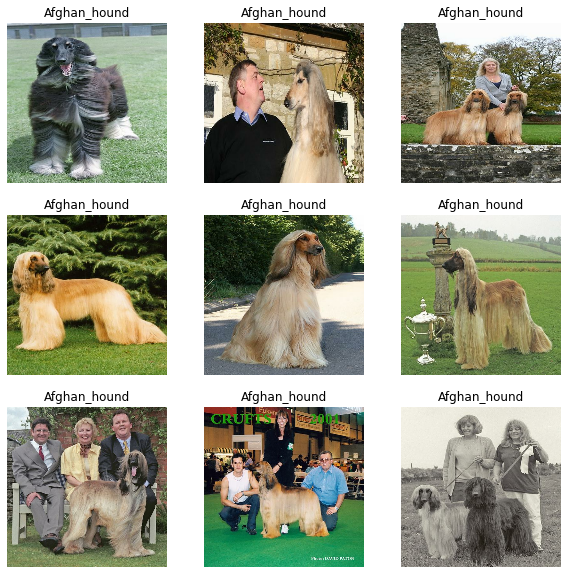

In [6]:
class_names = train_dataset.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")


In [7]:
val_batches = tf.data.experimental.cardinality(validation_dataset)
test_dataset = validation_dataset.take(val_batches // 5)
validation_dataset = validation_dataset.skip(val_batches // 5)
print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation_dataset))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))

Number of validation batches: 515
Number of test batches: 128


In [8]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

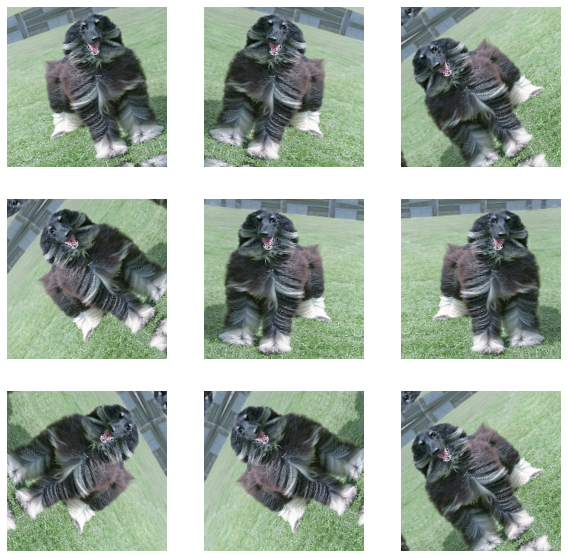

In [9]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
  tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
])
for image, _ in train_dataset.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

In [10]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

In [11]:
rescale = tf.keras.layers.experimental.preprocessing.Rescaling(1./127.5, offset= -1)

In [12]:
# Create the base model from the pre-trained model MobileNet V2
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

In [13]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 5, 5, 1280)


In [14]:
base_model.trainable = False

In [15]:
# Let's take a look at the base model architecture
base_model.summary()


xpand_relu[0][0]        
__________________________________________________________________________________________________
block_6_depthwise (DepthwiseCon (None, 10, 10, 192)  1728        block_6_pad[0][0]                
__________________________________________________________________________________________________
block_6_depthwise_BN (BatchNorm (None, 10, 10, 192)  768         block_6_depthwise[0][0]          
__________________________________________________________________________________________________
block_6_depthwise_relu (ReLU)   (None, 10, 10, 192)  0           block_6_depthwise_BN[0][0]       
__________________________________________________________________________________________________
block_6_project (Conv2D)        (None, 10, 10, 64)   12288       block_6_depthwise_relu[0][0]     
__________________________________________________________________________________________________
block_6_project_BN (BatchNormal (None, 10, 10, 64)   256         block_6_project[0][

In [16]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

prediction_layer = tf.keras.layers.Dense(1)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 1280)
(32, 1)


In [17]:
inputs = tf.keras.Input(shape=(160, 160, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [18]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 160, 160, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 160, 160, 3)       0         
_________________________________________________________________
tf.math.truediv (TFOpLambda) (None, 160, 160, 3)       0         
_________________________________________________________________
tf.math.subtract (TFOpLambda (None, 160, 160, 3)       0         
_________________________________________________________________
mobilenetv2_1.00_160 (Functi (None, 5, 5, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1280)              0     

In [19]:
initial_epochs = 1

loss0, accuracy0 = model.evaluate(validation_dataset)

515/515 [==============================] - 198s 359ms/step - loss: 0.6171 - accuracy: 0.0120


In [20]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

initial loss: 0.53
initial accuracy: 0.01


In [21]:
history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset)

515/515 [==============================] - 367s 707ms/step - loss: -982.9167 - accuracy: 0.0136 - val_loss: -1480.8657 - val_accuracy: 0.0085


In [22]:
from tensorflow.keras.applications import vgg16


In [23]:
vgg = vgg16()
vgg.summary()

TypeError: 'module' object is not callable

In [25]:
from tensorflow.keras.applications.vgg16 import VGG16
model=VGG16()


553467904/553467096 [==============================] - 27s 0us/step


In [26]:
model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [27]:
model.weights

loat32)>,
 <tf.Variable 'fc2/bias:0' shape=(4096,) dtype=float32, numpy=
 array([0.647107  , 0.48036072, 0.5855111 , ..., 0.5024527 , 0.41782504,
        0.66609925], dtype=float32)>,
 <tf.Variable 'predictions/kernel:0' shape=(4096, 1000) dtype=float32, numpy=
 array([[ 0.00338803,  0.00504329, -0.0032624 , ..., -0.00584898,
         -0.00315466,  0.01366626],
        [-0.00795877, -0.00110815, -0.00197206, ..., -0.00841791,
         -0.00452075, -0.00463977],
        [ 0.00034271,  0.00696493, -0.00256958, ..., -0.00680142,
          0.00583264,  0.00227   ],
        ...,
        [-0.00166638,  0.01209987, -0.00235068, ...,  0.00220267,
         -0.01347332, -0.01866422],
        [-0.00629507,  0.00078151, -0.0070783 , ...,  0.0162852 ,
         -0.0012129 , -0.00963307],
        [-0.00330952,  0.00706962, -0.01223338, ..., -0.00616068,
         -0.00658735,  0.01427563]], dtype=float32)>,
 <tf.Variable 'predictions/bias:0' shape=(1000,) dtype=float32, numpy=
 array([-2.12323606e-01,